In [1]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 370.8/370.8 KB 1.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 6.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 KB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 KB 3.4 MB/s eta 0:00:00
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=9434795 sha256=2267a47132d31d53861115a9e3dc98d158a27621118e6e77bac8928b758cbd63
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages tha

In [48]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from darts import TimeSeries
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

from darts.metrics import rmse

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Read dataset
dfcovid = pd.read_csv("../input/covidcgrt/owidOxCGRT.csv", delimiter = ',')
from darts.dataprocessing.transformers import Scaler
scaler = Scaler()

# Find date on which to split so that first 70% are training data and the remaining are test data
dateToSplit = dfcovid.date[int(0.7 * len(dfcovid))]
dateToSplit

'2021-06-26'

In [45]:
# Define alues for model parameters.
VAL_HIDDEN_DIM = 10
VAL_DROPOUT = 0.1
VAL_BATCH_SIZE = 128
VAL_N_EPOCHS = 256
VAL_TRAINING_LENGTH = 128
VAL_INPUT_CHUNK_LENGTH = 16
VAL_RANDOM_STATE = 123

In [5]:
# Attribute: new_cases
#creating TimeSeries
ts_new_cases = TimeSeries.from_dataframe(dfcovid, 'date', 'new_cases', fill_missing_dates = True, freq='D')
ts_new_cases_scaled = scaler.fit_transform(ts_new_cases)

# spliting dataset bbetween train and test
ts_new_cases_train, ts_new_cases_val = ts_new_cases_scaled.split_after(pd.Timestamp(dateToSplit))

#creating covariate series for month and year
year_series_new_cases = datetime_attribute_timeseries(
    pd.date_range(start=ts_new_cases.start_time(), freq=ts_new_cases.freq_str, periods=1000),
    attribute="year",
    one_hot=False,
)

year_series_new_cases = Scaler().fit_transform(year_series_new_cases)

month_series_new_cases = datetime_attribute_timeseries(
    year_series_new_cases, attribute="month", one_hot=True
)

covariates_new_cases = year_series_new_cases.stack(month_series_new_cases)
cov_train_new_cases, cov_val_new_cases = covariates_new_cases.split_after(pd.Timestamp(dateToSplit))


In [6]:
# Attribute: new_deaths
#creating TimeSeries
ts_new_deaths = TimeSeries.from_dataframe(dfcovid, 'date', 'new_deaths', fill_missing_dates = True, freq='D')
ts_new_deaths_scaled = scaler.fit_transform(ts_new_deaths)

# spliting dataset between train and test
ts_new_deaths_train, ts_new_deaths_val = ts_new_deaths_scaled.split_after(pd.Timestamp(dateToSplit))

#creating covariate series for month and year
year_series_new_deaths = datetime_attribute_timeseries(
    pd.date_range(start=ts_new_deaths.start_time(), freq=ts_new_cases.freq_str, periods=1000),
    attribute="year",
    one_hot=False,
)

year_series_new_deaths = Scaler().fit_transform(year_series_new_deaths)

month_series_new_deaths = datetime_attribute_timeseries(
    year_series_new_deaths, attribute="month", one_hot=True
)

covariates_new_deaths = year_series_new_deaths.stack(month_series_new_deaths)
cov_train_new_deaths, cov_val_new_deaths = covariates_new_deaths.split_after(pd.Timestamp(dateToSplit))


In [7]:
# Attribute: reproduction_rate
#creating TimeSeries
ts_reproduction_rate = TimeSeries.from_dataframe(dfcovid, 'date', 'reproduction_rate', fill_missing_dates = True, freq='D')
ts_reproduction_rate_scaled = scaler.fit_transform(ts_reproduction_rate)

# spliting dataset between train and test
ts_reproduction_rate_train, ts_reproduction_rate_val = ts_reproduction_rate_scaled.split_after(pd.Timestamp(dateToSplit))

#creating covariate series for month and year
year_series_reproduction_rate = datetime_attribute_timeseries(
    pd.date_range(start=ts_reproduction_rate.start_time(), freq=ts_reproduction_rate.freq_str, periods=1000),
    attribute="year",
    one_hot=False,
)

year_series_reproduction_rate = Scaler().fit_transform(year_series_reproduction_rate)

month_series_reproduction_rate = datetime_attribute_timeseries(
    year_series_reproduction_rate, attribute="month", one_hot=True
)

covariates_reproduction_rate = year_series_reproduction_rate.stack(month_series_reproduction_rate)
cov_train_reproduction_rate, cov_val_reproduction_rate = covariates_reproduction_rate.split_after(pd.Timestamp(dateToSplit))

In [8]:
# Attribute: new_tests 
#creating TimeSeries
ts_new_tests = TimeSeries.from_dataframe(dfcovid, 'date', 'new_tests', fill_missing_dates = True, freq='D')
ts_new_tests_scaled = scaler.fit_transform(ts_new_tests)

# spliting dataset between train and test
ts_new_tests_train, ts_new_tests_val = ts_new_tests_scaled.split_after(pd.Timestamp(dateToSplit))

#creating covariate series for month and year
year_series_new_tests = datetime_attribute_timeseries(
    pd.date_range(start=ts_new_tests.start_time(), freq=ts_new_tests.freq_str, periods=1000),
    attribute="year",
    one_hot=False,
)

year_series_new_tests = Scaler().fit_transform(year_series_new_tests)

month_series_new_tests = datetime_attribute_timeseries(
    year_series_new_tests, attribute="month", one_hot=True
)

covariates_new_tests = year_series_new_tests.stack(month_series_new_tests)
cov_train_new_tests, cov_val_new_tests = covariates_new_tests.split_after(pd.Timestamp(dateToSplit))

In [9]:
# Attribute: positive_rate 
#creating TimeSeries
ts_positive_rate = TimeSeries.from_dataframe(dfcovid, 'date', 'positive_rate', fill_missing_dates = True, freq='D')
ts_positive_rate_scaled = scaler.fit_transform(ts_positive_rate)

# spliting dataset between train and test
ts_positive_rate_train, ts_positive_rate_val = ts_positive_rate_scaled.split_after(pd.Timestamp(dateToSplit))

#creating covariate series for month and year
year_series_positive_rate = datetime_attribute_timeseries(
    pd.date_range(start=ts_positive_rate.start_time(), freq=ts_positive_rate.freq_str, periods=1000),
    attribute="year",
    one_hot=False,
)

year_series_positive_rate = Scaler().fit_transform(year_series_positive_rate)

month_series_positive_rate = datetime_attribute_timeseries(
    year_series_positive_rate, attribute="month", one_hot=True
)

covariates_positive_rate = year_series_positive_rate.stack(month_series_positive_rate)
cov_train_positive_rate, cov_val_positive_rate = covariates_positive_rate.split_after(pd.Timestamp(dateToSplit))

In [10]:
# Attribute: tests_per_case
#creating TimeSeries
ts_tests_per_case = TimeSeries.from_dataframe(dfcovid, 'date', 'tests_per_case', fill_missing_dates = True, freq='D')
ts_tests_per_case_scaled = scaler.fit_transform(ts_tests_per_case)

# spliting dataset between train and test
ts_tests_per_case_train, ts_tests_per_case_val = ts_tests_per_case_scaled.split_after(pd.Timestamp(dateToSplit))

#creating covariate series for month and year
year_series_tests_per_case = datetime_attribute_timeseries(
    pd.date_range(start=ts_tests_per_case.start_time(), freq=ts_tests_per_case.freq_str, periods=1000),
    attribute="year",
    one_hot=False,
)

year_series_tests_per_case = Scaler().fit_transform(year_series_tests_per_case)

month_series_tests_per_case = datetime_attribute_timeseries(
    year_series_tests_per_case, attribute="month", one_hot=True
)

covariates_tests_per_case = year_series_tests_per_case.stack(month_series_tests_per_case)
cov_train_tests_per_case, cov_val_tests_per_case = covariates_tests_per_case.split_after(pd.Timestamp(dateToSplit))

In [11]:
# Attribute: stringency_index
#creating TimeSeries
ts_stringency_index = TimeSeries.from_dataframe(dfcovid, 'date', 'stringency_index', fill_missing_dates = True, freq='D')
ts_stringency_index_scaled = scaler.fit_transform(ts_stringency_index)

# spliting dataset between train and test
ts_stringency_index_train, ts_stringency_index_val = ts_stringency_index_scaled.split_after(pd.Timestamp(dateToSplit))

#creating covariate series for month and year
year_series_stringency_index = datetime_attribute_timeseries(
    pd.date_range(start=ts_stringency_index.start_time(), freq=ts_stringency_index.freq_str, periods=1000),
    attribute="year",
    one_hot=False,
)

year_series_stringency_index = Scaler().fit_transform(year_series_stringency_index)

month_series_stringency_index = datetime_attribute_timeseries(
    year_series_stringency_index, attribute="month", one_hot=True
)

covariates_stringency_index = year_series_stringency_index.stack(month_series_stringency_index)
cov_train_stringency_index, cov_val_stringency_index = covariates_stringency_index.split_after(pd.Timestamp(dateToSplit))

In [12]:
# Attribute: C1_School_closing
#creating TimeSeries
ts_C1_School_closing = TimeSeries.from_dataframe(dfcovid, 'date', 'C1_School closing', fill_missing_dates = True, freq='D')
ts_C1_School_closing_scaled = scaler.fit_transform(ts_C1_School_closing)

# spliting dataset between train and test
ts_C1_School_closing_train, ts_C1_School_closing_val = ts_C1_School_closing_scaled.split_after(pd.Timestamp(dateToSplit))

#creating covariate series for month and year
year_series_C1_School_closing = datetime_attribute_timeseries(
    pd.date_range(start=ts_C1_School_closing.start_time(), freq=ts_C1_School_closing.freq_str, periods=1000),
    attribute="year",
    one_hot=False,
)

year_series_C1_School_closing = Scaler().fit_transform(year_series_C1_School_closing)

month_series_C1_School_closing = datetime_attribute_timeseries(
    year_series_C1_School_closing, attribute="month", one_hot=True
)

covariates_C1_School_closing = year_series_C1_School_closing.stack(month_series_C1_School_closing)
cov_train_C1_School_closing, cov_val_C1_School_closing = covariates_C1_School_closing.split_after(pd.Timestamp(dateToSplit))

In [13]:
# Attribute: C2_Workplace_closing
#creating TimeSeries
ts_C2_Workplace_closing = TimeSeries.from_dataframe(dfcovid, 'date', 'C2_Workplace closing', fill_missing_dates = True, freq='D')
ts_C2_Workplace_closing_scaled = scaler.fit_transform(ts_C2_Workplace_closing)

# spliting dataset between train and test
ts_C2_Workplace_closing_train, ts_C2_Workplace_closing_val = ts_C2_Workplace_closing_scaled.split_after(pd.Timestamp(dateToSplit))

#creating covariate series for month and year
year_series_C2_Workplace_closing = datetime_attribute_timeseries(
    pd.date_range(start=ts_C2_Workplace_closing.start_time(), freq=ts_C2_Workplace_closing.freq_str, periods=1000),
    attribute="year",
    one_hot=False,
)

year_series_C2_Workplace_closing = Scaler().fit_transform(year_series_C2_Workplace_closing)

month_series_C2_Workplace_closing = datetime_attribute_timeseries(
    year_series_C2_Workplace_closing, attribute="month", one_hot=True
)

covariates_C2_Workplace_closing = year_series_C2_Workplace_closing.stack(month_series_C2_Workplace_closing)
cov_train_C2_Workplace_closing, cov_val_C2_Workplace_closing = covariates_C2_Workplace_closing.split_after(pd.Timestamp(dateToSplit))

In [14]:
# Attribute: C3_Cancel_public_events
#creating TimeSeries
ts_C3_Cancel_public_events = TimeSeries.from_dataframe(dfcovid, 'date', 'C3_Cancel public events', fill_missing_dates = True, freq='D')
ts_C3_Cancel_public_events_scaled = scaler.fit_transform(ts_C3_Cancel_public_events)

# spliting dataset between train and test
ts_C3_Cancel_public_events_train, ts_C3_Cancel_public_events_val = ts_C3_Cancel_public_events_scaled.split_after(pd.Timestamp(dateToSplit))

#creating covariate series for month and year
year_series_C3_Cancel_public_events = datetime_attribute_timeseries(
    pd.date_range(start=ts_C3_Cancel_public_events.start_time(), freq=ts_C3_Cancel_public_events.freq_str, periods=1000),
    attribute="year",
    one_hot=False,
)

year_series_C3_Cancel_public_events = Scaler().fit_transform(year_series_C3_Cancel_public_events)

month_series_C3_Cancel_public_events = datetime_attribute_timeseries(
    year_series_C3_Cancel_public_events, attribute="month", one_hot=True
)

covariates_C3_Cancel_public_events = year_series_C3_Cancel_public_events.stack(month_series_C3_Cancel_public_events)
cov_train_C3_Cancel_public_events, cov_val_C3_Cancel_public_events = covariates_C3_Cancel_public_events.split_after(pd.Timestamp(dateToSplit))

In [15]:
# Attribute: C4_Restrictions_on_gatherings 
#creating TimeSeries
ts_C4_Restrictions_on_gatherings = TimeSeries.from_dataframe(dfcovid, 'date', 'C4_Restrictions on gatherings', fill_missing_dates = True, freq='D')
ts_C4_Restrictions_on_gatherings_scaled = scaler.fit_transform(ts_C4_Restrictions_on_gatherings)

# spliting dataset between train and test
ts_C4_Restrictions_on_gatherings_train, ts_C4_Restrictions_on_gatherings_val = ts_C4_Restrictions_on_gatherings_scaled.split_after(pd.Timestamp(dateToSplit))

#creating covariate series for month and year
year_series_C4_Restrictions_on_gatherings = datetime_attribute_timeseries(
    pd.date_range(start=ts_C4_Restrictions_on_gatherings.start_time(), freq=ts_C4_Restrictions_on_gatherings.freq_str, periods=1000),
    attribute="year",
    one_hot=False,
)

year_series_C4_Restrictions_on_gatherings = Scaler().fit_transform(year_series_C4_Restrictions_on_gatherings)

month_series_C4_Restrictions_on_gatherings = datetime_attribute_timeseries(
    year_series_C4_Restrictions_on_gatherings, attribute="month", one_hot=True
)

covariates_C4_Restrictions_on_gatherings = year_series_C4_Restrictions_on_gatherings.stack(month_series_C4_Restrictions_on_gatherings)
cov_train_C4_Restrictions_on_gatherings, cov_val_C4_Restrictions_on_gatherings = covariates_C4_Restrictions_on_gatherings.split_after(pd.Timestamp(dateToSplit))

In [16]:
# Attribute: C5_Close_public_transport
#creating TimeSeries
ts_C5_Close_public_transport = TimeSeries.from_dataframe(dfcovid, 'date', 'C5_Close public transport', fill_missing_dates = True, freq='D')
ts_C5_Close_public_transport_scaled = scaler.fit_transform(ts_C5_Close_public_transport)

# spliting dataset between train and test
ts_C5_Close_public_transport_train, ts_C5_Close_public_transport_val = ts_C5_Close_public_transport_scaled.split_after(pd.Timestamp(dateToSplit))

#creating covariate series for month and year
year_series_C5_Close_public_transport = datetime_attribute_timeseries(
    pd.date_range(start=ts_C5_Close_public_transport.start_time(), freq=ts_C5_Close_public_transport.freq_str, periods=1000),
    attribute="year",
    one_hot=False,
)

year_series_C5_Close_public_transport = Scaler().fit_transform(year_series_C5_Close_public_transport)

month_series_C5_Close_public_transport = datetime_attribute_timeseries(
    year_series_C5_Close_public_transport, attribute="month", one_hot=True
)

covariates_C5_Close_public_transport = year_series_C5_Close_public_transport.stack(month_series_C5_Close_public_transport)
cov_train_C5_Close_public_transport, cov_val_C5_Close_public_transport = covariates_C5_Close_public_transport.split_after(pd.Timestamp(dateToSplit))

In [17]:
# Attribute: C6_Stay_at_home_requirements
#creating TimeSeries
ts_C6_Stay_at_home_requirements = TimeSeries.from_dataframe(dfcovid, 'date', 'C6_Stay at home requirements', fill_missing_dates = True, freq='D')
ts_C6_Stay_at_home_requirements_scaled = scaler.fit_transform(ts_C6_Stay_at_home_requirements)

# spliting dataset between train and test
ts_C6_Stay_at_home_requirements_train, ts_C6_Stay_at_home_requirements_val = ts_C6_Stay_at_home_requirements_scaled.split_after(pd.Timestamp(dateToSplit))

#creating covariate series for month and year
year_series_C6_Stay_at_home_requirements = datetime_attribute_timeseries(
    pd.date_range(start=ts_C6_Stay_at_home_requirements.start_time(), freq=ts_C6_Stay_at_home_requirements.freq_str, periods=1000),
    attribute="year",
    one_hot=False,
)

year_series_C6_Stay_at_home_requirements = Scaler().fit_transform(year_series_C6_Stay_at_home_requirements)

month_series_C6_Stay_at_home_requirements = datetime_attribute_timeseries(
    year_series_C6_Stay_at_home_requirements, attribute="month", one_hot=True
)

covariates_C6_Stay_at_home_requirements = year_series_C6_Stay_at_home_requirements.stack(month_series_C6_Stay_at_home_requirements)
cov_train_C6_Stay_at_home_requirements, cov_val_C6_Stay_at_home_requirements = covariates_C6_Stay_at_home_requirements.split_after(pd.Timestamp(dateToSplit))

In [18]:
# Attribute: C7_Restrictions_on_internal_movement 
#creating TimeSeries
ts_C7_Restrictions_on_internal_movement = TimeSeries.from_dataframe(dfcovid, 'date', 'C7_Restrictions on internal movement', fill_missing_dates = True, freq='D')
ts_C7_Restrictions_on_internal_movement_scaled = scaler.fit_transform(ts_C7_Restrictions_on_internal_movement)

# spliting dataset between train and test
ts_C7_Restrictions_on_internal_movement_train, ts_C7_Restrictions_on_internal_movement_val = ts_C7_Restrictions_on_internal_movement_scaled.split_after(pd.Timestamp(dateToSplit))

#creating covariate series for month and year
year_series_C7_Restrictions_on_internal_movement = datetime_attribute_timeseries(
    pd.date_range(start=ts_C7_Restrictions_on_internal_movement.start_time(), freq=ts_C7_Restrictions_on_internal_movement.freq_str, periods=1000),
    attribute="year",
    one_hot=False,
)

year_series_C7_Restrictions_on_internal_movement = Scaler().fit_transform(year_series_C7_Restrictions_on_internal_movement)

month_series_C7_Restrictions_on_internal_movement = datetime_attribute_timeseries(
    year_series_C7_Restrictions_on_internal_movement, attribute="month", one_hot=True
)

covariates_C7_Restrictions_on_internal_movement = year_series_C7_Restrictions_on_internal_movement.stack(month_series_C7_Restrictions_on_internal_movement)
cov_train_C7_Restrictions_on_internal_movement, cov_val_C7_Restrictions_on_internal_movement = covariates_C7_Restrictions_on_internal_movement.split_after(pd.Timestamp(dateToSplit))

In [19]:
# Attribute: H2_Testing_policy 
#creating TimeSeries
ts_H2_Testing_policy = TimeSeries.from_dataframe(dfcovid, 'date', 'H2_Testing policy', fill_missing_dates = True, freq='D')
ts_H2_Testing_policy_scaled = scaler.fit_transform(ts_H2_Testing_policy)

# spliting dataset between train and test
ts_H2_Testing_policy_train, ts_H2_Testing_policy_val = ts_H2_Testing_policy_scaled.split_after(pd.Timestamp(dateToSplit))

#creating covariate series for month and year
year_series_H2_Testing_policy = datetime_attribute_timeseries(
    pd.date_range(start=ts_H2_Testing_policy.start_time(), freq=ts_H2_Testing_policy.freq_str, periods=1000),
    attribute="year",
    one_hot=False,
)

year_series_H2_Testing_policy = Scaler().fit_transform(year_series_H2_Testing_policy)

month_series_H2_Testing_policy = datetime_attribute_timeseries(
    year_series_H2_Testing_policy, attribute="month", one_hot=True
)

covariates_H2_Testing_policy = year_series_H2_Testing_policy.stack(month_series_H2_Testing_policy)
cov_train_H2_Testing_policy, cov_val_H2_Testing_policy = covariates_H2_Testing_policy.split_after(pd.Timestamp(dateToSplit))

In [20]:
# Attribute: H7_Vaccination_policy
#creating TimeSeries
ts_H7_Vaccination_policy = TimeSeries.from_dataframe(dfcovid, 'date', 'H7_Vaccination policy', fill_missing_dates = True, freq='D')
ts_H7_Vaccination_policy_scaled = scaler.fit_transform(ts_H7_Vaccination_policy)

# spliting dataset between train and test
ts_H7_Vaccination_policy_train, ts_H7_Vaccination_policy_val = ts_H7_Vaccination_policy_scaled.split_after(pd.Timestamp(dateToSplit))

#creating covariate series for month and year
year_series_H7_Vaccination_policy = datetime_attribute_timeseries(
    pd.date_range(start=ts_H7_Vaccination_policy.start_time(), freq=ts_H7_Vaccination_policy.freq_str, periods=1000),
    attribute="year",
    one_hot=False,
)

year_series_H7_Vaccination_policy = Scaler().fit_transform(year_series_H7_Vaccination_policy)

month_series_H7_Vaccination_policy = datetime_attribute_timeseries(
    year_series_H7_Vaccination_policy, attribute="month", one_hot=True
)

covariates_H7_Vaccination_policy = year_series_H7_Vaccination_policy.stack(month_series_H7_Vaccination_policy)
cov_train_H7_Vaccination_policy, cov_val_H7_Vaccination_policy = covariates_H7_Vaccination_policy.split_after(pd.Timestamp(dateToSplit))

In [21]:
# Attribute: H8_Protection_of_elderly_people
#creating TimeSeries
ts_H8_Protection_of_elderly_people = TimeSeries.from_dataframe(dfcovid, 'date', 'H8_Protection of elderly people', fill_missing_dates = True, freq='D')
ts_H8_Protection_of_elderly_people_scaled = scaler.fit_transform(ts_H8_Protection_of_elderly_people)

# spliting dataset between train and test
ts_H8_Protection_of_elderly_people_train, ts_H8_Protection_of_elderly_people_val = ts_H8_Protection_of_elderly_people_scaled.split_after(pd.Timestamp(dateToSplit))

#creating covariate series for month and year
year_series_H8_Protection_of_elderly_people = datetime_attribute_timeseries(
    pd.date_range(start=ts_H8_Protection_of_elderly_people.start_time(), freq=ts_H8_Protection_of_elderly_people.freq_str, periods=1000),
    attribute="year",
    one_hot=False,
)

year_series_H8_Protection_of_elderly_people = Scaler().fit_transform(year_series_H7_Vaccination_policy)

month_series_H8_Protection_of_elderly_people = datetime_attribute_timeseries(
    year_series_H8_Protection_of_elderly_people, attribute="month", one_hot=True
)

covariates_H8_Protection_of_elderly_people = year_series_H8_Protection_of_elderly_people.stack(month_series_H8_Protection_of_elderly_people)
cov_train_H8_Protection_of_elderly_people, cov_val_H8_Protection_of_elderly_people = covariates_H8_Protection_of_elderly_people.split_after(pd.Timestamp(dateToSplit))

In [22]:
# Attribute: new_cases
# Create LSTM model
#RNN Model creation and fitting it
# retail_and_recreation_percent_change
LSTM_model_new_cases = RNNModel(
    model="LSTM",
    hidden_dim = VAL_HIDDEN_DIM,
    dropout = VAL_DROPOUT,
    batch_size = VAL_BATCH_SIZE,
    n_epochs = VAL_N_EPOCHS,
    optimizer_kwargs={"lr": 1e-3},
    model_name="LSTM Model 1",
    log_tensorboard = True,
    random_state = VAL_RANDOM_STATE,
    training_length = VAL_TRAINING_LENGTH,
    input_chunk_length = VAL_INPUT_CHUNK_LENGTH,
    force_reset = True,
    save_checkpoints = True)

LSTM_model_new_cases.fit(
   ts_new_cases_train,
   future_covariates = covariates_new_cases,
    val_series = ts_new_cases_val,
   val_future_covariates = covariates_new_cases,
    verbose=False)

In [23]:
# Attribute: new_cases
# Create LSTM model
#RNN Model creation and fitting it
LSTM_model_new_cases = RNNModel(
    model="LSTM",
    hidden_dim = VAL_HIDDEN_DIM,
    dropout = VAL_DROPOUT,
    batch_size = VAL_BATCH_SIZE,
    n_epochs = VAL_N_EPOCHS,
    optimizer_kwargs={"lr": 1e-3},
    model_name="LSTM Model 1",
    log_tensorboard = True,
    random_state = VAL_RANDOM_STATE,
    training_length = VAL_TRAINING_LENGTH,
    input_chunk_length = VAL_INPUT_CHUNK_LENGTH,
    force_reset = True,
    save_checkpoints = True)

LSTM_model_new_cases.fit(
   ts_new_cases_train,
   future_covariates = covariates_new_cases,
    val_series = ts_new_cases_val,
   val_future_covariates = covariates_new_cases,
    verbose=False)

In [24]:
# Attribute: new_deaths 
# Create LSTM model
#RNN Model creation and fitting it
LSTM_model_new_deaths = RNNModel(
    model="LSTM",
    hidden_dim = VAL_HIDDEN_DIM,
    dropout = VAL_DROPOUT,
    batch_size = VAL_BATCH_SIZE,
    n_epochs = VAL_N_EPOCHS,
    optimizer_kwargs={"lr": 1e-3},
    model_name="LSTM Model 2",
    log_tensorboard = True,
    random_state = VAL_RANDOM_STATE,
    training_length = VAL_TRAINING_LENGTH,
    input_chunk_length = VAL_INPUT_CHUNK_LENGTH,
    force_reset = True,
    save_checkpoints = True)

LSTM_model_new_deaths.fit(
   ts_new_deaths_train,
   future_covariates = covariates_new_deaths,
    val_series = ts_new_deaths_val,
   val_future_covariates = covariates_new_deaths,
    verbose=False)

In [25]:
# Attribute: reproduction_rate  
# Create LSTM model
#RNN Model creation and fitting it
LSTM_model_reproduction_rate = RNNModel(
    model="LSTM",
    hidden_dim = VAL_HIDDEN_DIM,
    dropout = VAL_DROPOUT,
    batch_size = VAL_BATCH_SIZE,
    n_epochs = VAL_N_EPOCHS,
    optimizer_kwargs={"lr": 1e-3},
    model_name="LSTM Model 3",
    log_tensorboard = True,
    random_state = VAL_RANDOM_STATE,
    training_length = VAL_TRAINING_LENGTH,
    input_chunk_length = VAL_INPUT_CHUNK_LENGTH,
    force_reset = True,
    save_checkpoints = True)

LSTM_model_reproduction_rate.fit(
   ts_reproduction_rate_train,
   future_covariates = covariates_reproduction_rate,
    val_series = ts_reproduction_rate_val,
   val_future_covariates = covariates_reproduction_rate,
    verbose=False)

In [26]:
# Attribute: new_tests  
# Create LSTM model
#RNN Model creation and fitting it
LSTM_model_new_tests = RNNModel(
    model="LSTM",
    hidden_dim = VAL_HIDDEN_DIM,
    dropout = VAL_DROPOUT,
    batch_size = VAL_BATCH_SIZE,
    n_epochs = VAL_N_EPOCHS,
    optimizer_kwargs={"lr": 1e-3},
    model_name="LSTM Model 4",
    log_tensorboard = True,
    random_state = VAL_RANDOM_STATE,
    training_length = VAL_TRAINING_LENGTH,
    input_chunk_length = VAL_INPUT_CHUNK_LENGTH,
    force_reset = True,
    save_checkpoints = True)

LSTM_model_new_tests.fit(
   ts_new_tests_train,
   future_covariates = covariates_new_tests,
    val_series = ts_new_tests_val,
   val_future_covariates = covariates_new_tests,
    verbose=False)

In [27]:
# Attribute: positive_rate   
# Create LSTM model
#RNN Model creation and fitting it
LSTM_model_positive_rate = RNNModel(
    model="LSTM",
    hidden_dim = VAL_HIDDEN_DIM,
    dropout = VAL_DROPOUT,
    batch_size = VAL_BATCH_SIZE,
    n_epochs = VAL_N_EPOCHS,
    optimizer_kwargs={"lr": 1e-3},
    model_name="LSTM Model 5",
    log_tensorboard = True,
    random_state = VAL_RANDOM_STATE,
    training_length = VAL_TRAINING_LENGTH,
    input_chunk_length = VAL_INPUT_CHUNK_LENGTH,
    force_reset = True,
    save_checkpoints = True)

LSTM_model_positive_rate.fit(
   ts_positive_rate_train,
   future_covariates = covariates_positive_rate,
    val_series = ts_positive_rate_val,
   val_future_covariates = covariates_positive_rate,
    verbose=False)

In [28]:
# Attribute: tests_per_case    
# Create LSTM model
#RNN Model creation and fitting it
LSTM_model_tests_per_case = RNNModel(
    model="LSTM",
    hidden_dim = VAL_HIDDEN_DIM,
    dropout = VAL_DROPOUT,
    batch_size = VAL_BATCH_SIZE,
    n_epochs = VAL_N_EPOCHS,
    optimizer_kwargs={"lr": 1e-3},
    model_name="LSTM Model 6",
    log_tensorboard = True,
    random_state = VAL_RANDOM_STATE,
    training_length = VAL_TRAINING_LENGTH,
    input_chunk_length = VAL_INPUT_CHUNK_LENGTH,
    force_reset = True,
    save_checkpoints = True)

LSTM_model_tests_per_case.fit(
   ts_tests_per_case_train,
   future_covariates = covariates_tests_per_case,
    val_series = ts_tests_per_case_val,
   val_future_covariates = covariates_tests_per_case,
    verbose=False)

In [29]:
# Attribute: stringency_index    
# Create LSTM model
#RNN Model creation and fitting it
LSTM_model_stringency_index = RNNModel(
    model="LSTM",
    hidden_dim = VAL_HIDDEN_DIM,
    dropout = VAL_DROPOUT,
    batch_size = VAL_BATCH_SIZE,
    n_epochs = VAL_N_EPOCHS,
    optimizer_kwargs={"lr": 1e-3},
    model_name="LSTM Model 8",
    log_tensorboard = True,
    random_state = VAL_RANDOM_STATE,
    training_length = VAL_TRAINING_LENGTH,
    input_chunk_length = VAL_INPUT_CHUNK_LENGTH,
    force_reset = True,
    save_checkpoints = True)

LSTM_model_stringency_index.fit(
   ts_stringency_index_train,
   future_covariates = covariates_stringency_index,
    val_series = ts_stringency_index_val,
   val_future_covariates = covariates_stringency_index,
    verbose=False)

In [30]:
# Attribute: C1_School_closing  
# Create LSTM model
#RNN Model creation and fitting it
LSTM_model_C1_School_closing = RNNModel(
    model="LSTM",
    hidden_dim = VAL_HIDDEN_DIM,
    dropout = VAL_DROPOUT,
    batch_size = VAL_BATCH_SIZE,
    n_epochs = VAL_N_EPOCHS,
    optimizer_kwargs={"lr": 1e-3},
    model_name="LSTM Model 9",
    log_tensorboard = True,
    random_state = VAL_RANDOM_STATE,
    training_length = VAL_TRAINING_LENGTH,
    input_chunk_length = VAL_INPUT_CHUNK_LENGTH,
    force_reset = True,
    save_checkpoints = True)

LSTM_model_C1_School_closing.fit(
   ts_C1_School_closing_train,
   future_covariates = covariates_C1_School_closing,
    val_series = ts_C1_School_closing_val,
   val_future_covariates = covariates_C1_School_closing,
    verbose=False)

In [31]:
# Attribute: C2_Workplace_closing 
# Create LSTM model
#RNN Model creation and fitting it
LSTM_model_C2_Workplace_closing = RNNModel(
    model="LSTM",
    hidden_dim = VAL_HIDDEN_DIM,
    dropout = VAL_DROPOUT,
    batch_size = VAL_BATCH_SIZE,
    n_epochs = VAL_N_EPOCHS,
    optimizer_kwargs={"lr": 1e-3},
    model_name="LSTM Model 10",
    log_tensorboard = True,
    random_state = VAL_RANDOM_STATE,
    training_length = VAL_TRAINING_LENGTH,
    input_chunk_length = VAL_INPUT_CHUNK_LENGTH,
    force_reset = True,
    save_checkpoints = True)

LSTM_model_C2_Workplace_closing.fit(
   ts_C2_Workplace_closing_train,
   future_covariates = covariates_C2_Workplace_closing,
    val_series = ts_C2_Workplace_closing_val,
   val_future_covariates = covariates_C2_Workplace_closing,
    verbose=False)

In [32]:
# Attribute: C3_Cancel_public_events 
# Create LSTM model
#RNN Model creation and fitting it
LSTM_model_C3_Cancel_public_events = RNNModel(
    model="LSTM",
    hidden_dim = VAL_HIDDEN_DIM,
    dropout = VAL_DROPOUT,
    batch_size = VAL_BATCH_SIZE,
    n_epochs = VAL_N_EPOCHS,
    optimizer_kwargs={"lr": 1e-3},
    model_name="LSTM Model 11",
    log_tensorboard = True,
    random_state = VAL_RANDOM_STATE,
    training_length = VAL_TRAINING_LENGTH,
    input_chunk_length = VAL_INPUT_CHUNK_LENGTH,
    force_reset = True,
    save_checkpoints = True)

LSTM_model_C3_Cancel_public_events.fit(
   ts_C3_Cancel_public_events_train,
   future_covariates = covariates_C3_Cancel_public_events,
    val_series = ts_C3_Cancel_public_events_val,
   val_future_covariates = covariates_C3_Cancel_public_events,
    verbose=False)

In [33]:
# Attribute: C4_Restrictions_on_gatherings
# Create LSTM model
#RNN Model creation and fitting it
LSTM_model_C4_Restrictions_on_gatherings = RNNModel(
    model="LSTM",
    hidden_dim = VAL_HIDDEN_DIM,
    dropout = VAL_DROPOUT,
    batch_size = VAL_BATCH_SIZE,
    n_epochs = VAL_N_EPOCHS,
    optimizer_kwargs={"lr": 1e-3},
    model_name="LSTM Model 12",
    log_tensorboard = True,
    random_state = VAL_RANDOM_STATE,
    training_length = VAL_TRAINING_LENGTH,
    input_chunk_length = VAL_INPUT_CHUNK_LENGTH,
    force_reset = True,
    save_checkpoints = True)

LSTM_model_C4_Restrictions_on_gatherings.fit(
   ts_C4_Restrictions_on_gatherings_train,
   future_covariates = covariates_C4_Restrictions_on_gatherings,
    val_series = ts_C4_Restrictions_on_gatherings_val,
   val_future_covariates = covariates_C4_Restrictions_on_gatherings,
    verbose=False)

In [34]:
# Attribute: C5_Close_public_transport
# Create LSTM model
#RNN Model creation and fitting it
LSTM_model_C5_Close_public_transport = RNNModel(
    model="LSTM",
    hidden_dim = VAL_HIDDEN_DIM,
    dropout = VAL_DROPOUT,
    batch_size = VAL_BATCH_SIZE,
    n_epochs = VAL_N_EPOCHS,
    optimizer_kwargs={"lr": 1e-3},
    model_name="LSTM Model 13",
    log_tensorboard = True,
    random_state = VAL_RANDOM_STATE,
    training_length = VAL_TRAINING_LENGTH,
    input_chunk_length = VAL_INPUT_CHUNK_LENGTH,
    force_reset = True,
    save_checkpoints = True)

LSTM_model_C5_Close_public_transport.fit(
   ts_C5_Close_public_transport_train,
   future_covariates = covariates_C5_Close_public_transport,
    val_series = ts_C5_Close_public_transport_val,
   val_future_covariates = covariates_C5_Close_public_transport,
    verbose=False)

In [35]:
# Attribute: C6_Stay_at_home_requirements 
# Create LSTM model
#RNN Model creation and fitting it
LSTM_model_C6_Stay_at_home_requirements = RNNModel(
    model="LSTM",
    hidden_dim = VAL_HIDDEN_DIM,
    dropout = VAL_DROPOUT,
    batch_size = VAL_BATCH_SIZE,
    n_epochs = VAL_N_EPOCHS,
    optimizer_kwargs={"lr": 1e-3},
    model_name="LSTM Model 14",
    log_tensorboard = True,
    random_state = VAL_RANDOM_STATE,
    training_length = VAL_TRAINING_LENGTH,
    input_chunk_length = VAL_INPUT_CHUNK_LENGTH,
    force_reset = True,
    save_checkpoints = True)

LSTM_model_C6_Stay_at_home_requirements.fit(
   ts_C6_Stay_at_home_requirements_train,
   future_covariates = covariates_C6_Stay_at_home_requirements,
    val_series = ts_C6_Stay_at_home_requirements_val,
   val_future_covariates = covariates_C6_Stay_at_home_requirements,
    verbose=False)

In [36]:
# Attribute: C7_Restrictions_on_internal_movement  
# Create LSTM model
#RNN Model creation and fitting it
LSTM_model_C7_Restrictions_on_internal_movement = RNNModel(
    model="LSTM",
    hidden_dim = VAL_HIDDEN_DIM,
    dropout = VAL_DROPOUT,
    batch_size = VAL_BATCH_SIZE,
    n_epochs = VAL_N_EPOCHS,
    optimizer_kwargs={"lr": 1e-3},
    model_name="LSTM Model 15",
    log_tensorboard = True,
    random_state = VAL_RANDOM_STATE,
    training_length = VAL_TRAINING_LENGTH,
    input_chunk_length = VAL_INPUT_CHUNK_LENGTH,
    force_reset = True,
    save_checkpoints = True)

LSTM_model_C7_Restrictions_on_internal_movement.fit(
   ts_C7_Restrictions_on_internal_movement_train,
   future_covariates = covariates_C7_Restrictions_on_internal_movement,
    val_series = ts_C7_Restrictions_on_internal_movement_val,
   val_future_covariates = covariates_C7_Restrictions_on_internal_movement,
    verbose=False)

In [37]:
# Attribute: H2_Testing_policy   
# Create LSTM model
#RNN Model creation and fitting it
LSTM_model_H2_Testing_policy = RNNModel(
    model="LSTM",
    hidden_dim = VAL_HIDDEN_DIM,
    dropout = VAL_DROPOUT,
    batch_size = VAL_BATCH_SIZE,
    n_epochs = VAL_N_EPOCHS,
    optimizer_kwargs={"lr": 1e-3},
    model_name="LSTM Model 16",
    log_tensorboard = True,
    random_state = VAL_RANDOM_STATE,
    training_length = VAL_TRAINING_LENGTH,
    input_chunk_length = VAL_INPUT_CHUNK_LENGTH,
    force_reset = True,
    save_checkpoints = True)

LSTM_model_H2_Testing_policy.fit(
   ts_H2_Testing_policy_train,
   future_covariates = covariates_H2_Testing_policy,
    val_series = ts_H2_Testing_policy_val,
   val_future_covariates = covariates_H2_Testing_policy,
    verbose=False)

In [38]:
# Attribute: H7_Vaccination_policy  
# Create LSTM model
#RNN Model creation and fitting it
LSTM_model_H7_Vaccination_policy = RNNModel(
    model="LSTM",
    hidden_dim = VAL_HIDDEN_DIM,
    dropout = VAL_DROPOUT,
    batch_size = VAL_BATCH_SIZE,
    n_epochs = VAL_N_EPOCHS,
    optimizer_kwargs={"lr": 1e-3},
    model_name="LSTM Model 17",
    log_tensorboard = True,
    random_state = VAL_RANDOM_STATE,
    training_length = VAL_TRAINING_LENGTH,
    input_chunk_length = VAL_INPUT_CHUNK_LENGTH,
    force_reset = True,
    save_checkpoints = True)

LSTM_model_H7_Vaccination_policy.fit(
   ts_H7_Vaccination_policy_train,
   future_covariates = covariates_H7_Vaccination_policy,
    val_series = ts_H7_Vaccination_policy_val,
   val_future_covariates = covariates_H7_Vaccination_policy,
    verbose=False)

In [39]:
# Attribute: H8_Protection_of_elderly_people 
# Create LSTM model
#RNN Model creation and fitting it
LSTM_model_H8_Protection_of_elderly_people = RNNModel(
    model="LSTM",
    hidden_dim = VAL_HIDDEN_DIM,
    dropout = VAL_DROPOUT,
    batch_size = VAL_BATCH_SIZE,
    n_epochs = VAL_N_EPOCHS,
    optimizer_kwargs={"lr": 1e-3},
    model_name="LSTM Model 18",
    log_tensorboard = True,
    random_state = VAL_RANDOM_STATE,
    training_length = VAL_TRAINING_LENGTH,
    input_chunk_length = VAL_INPUT_CHUNK_LENGTH,
    force_reset = True,
    save_checkpoints = True)

LSTM_model_H8_Protection_of_elderly_people.fit(
   ts_H8_Protection_of_elderly_people_train,
   future_covariates = covariates_H8_Protection_of_elderly_people,
    val_series = ts_H8_Protection_of_elderly_people_val,
   val_future_covariates = covariates_H8_Protection_of_elderly_people,
    verbose=False)

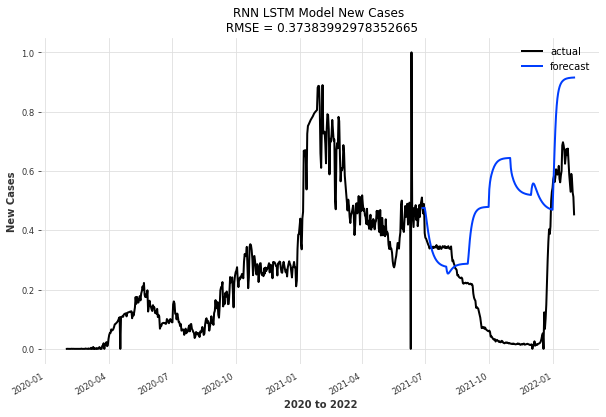

In [67]:
# Attribute: new_cases
# Evaluating and plotting model
n_val_new_cases = len(ts_new_cases_val)

def eval_model_new_cases(model):
    pred_series = model.predict(n = n_val_new_cases, future_covariates = covariates_new_cases)
    plt.figure(figsize=(10, 6))
    ts_new_cases_scaled.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title('RNN LSTM Model New Cases \n RMSE = {}'.format(rmse(pred_series, ts_new_cases_val)))
    plt.xlabel('2020 to 2022')
    plt.ylabel('New Cases')
    plt.legend()

eval_model_new_cases(LSTM_model_new_cases)

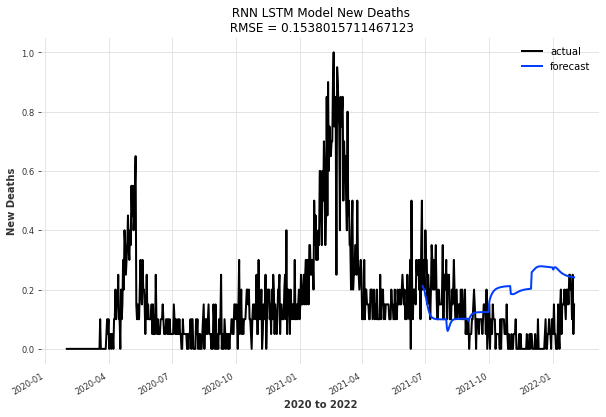

In [68]:
# Attribute: new_deaths 
# Evaluating and plotting model
n_val_new_deaths = len(ts_new_deaths_val)

def eval_model_new_deaths(model):
    pred_series = model.predict(n = n_val_new_deaths, future_covariates = covariates_new_deaths)
    plt.figure(figsize=(10, 6))
    ts_new_deaths_scaled.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title(' RNN LSTM Model New Deaths \n RMSE = {}'.format(rmse(pred_series, ts_new_deaths_val)))
    plt.xlabel('2020 to 2022')
    plt.ylabel('New Deaths')
    plt.legend()

eval_model_new_deaths(LSTM_model_new_deaths)

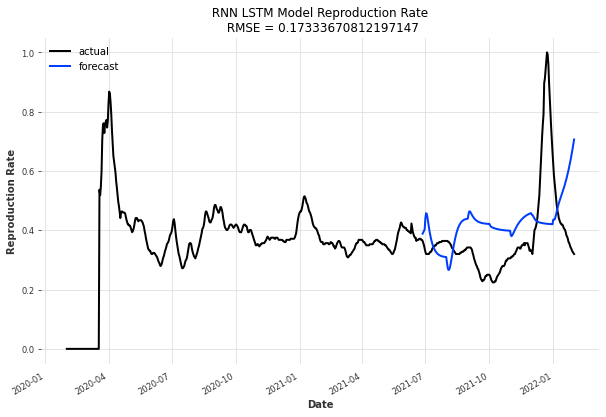

In [69]:
# Attribute: reproduction_rate  
# Evaluating and plotting model
n_val_reproduction_rate = len(ts_reproduction_rate_val)

def eval_model_reproduction_rate(model):
    pred_series = model.predict(n = n_val_reproduction_rate, future_covariates = covariates_reproduction_rate)
    plt.figure(figsize=(10, 6))
    ts_reproduction_rate_scaled.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title(' RNN LSTM Model Reproduction Rate \n RMSE = {}'.format(rmse(pred_series, ts_reproduction_rate_val)))
    plt.xlabel('Date')
    plt.ylabel('Reproduction Rate')
    plt.legend()

eval_model_reproduction_rate(LSTM_model_reproduction_rate)

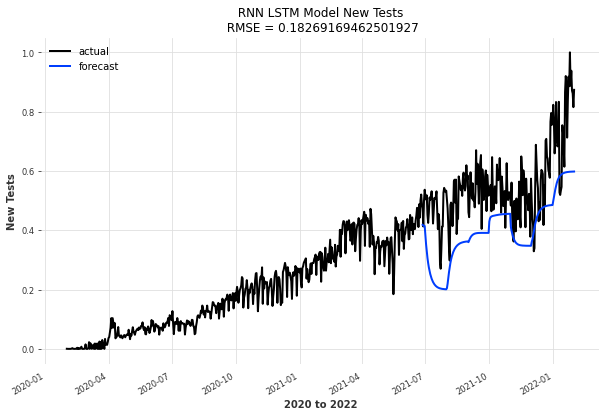

In [70]:
# Attribute: new_tests   
# Evaluating and plotting model
n_val_new_tests = len(ts_new_tests_val)

def eval_model_new_tests(model):
    pred_series = model.predict(n = n_val_new_tests, future_covariates = covariates_new_tests)
    plt.figure(figsize=(10, 6))
    ts_new_tests_scaled.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title(' RNN LSTM Model New Tests \n RMSE = {}'.format(rmse(pred_series, ts_new_tests_val)))
    plt.xlabel('2020 to 2022')
    plt.ylabel('New Tests')
    plt.legend()

eval_model_new_tests(LSTM_model_new_tests)

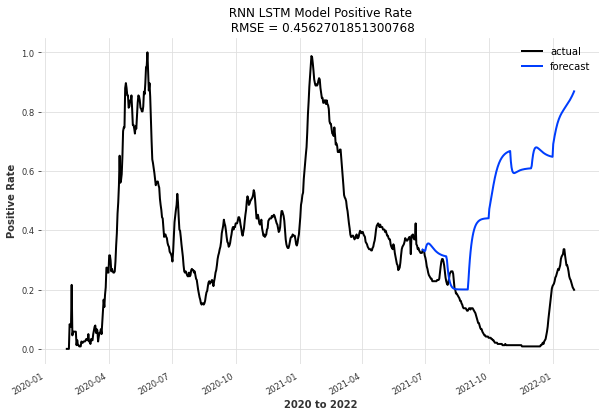

In [71]:
# Attribute: positive_rate   
# Evaluating and plotting model
n_val_positive_rate = len(ts_positive_rate_val)

def eval_model_positive_rate(model):
    pred_series = model.predict(n = n_val_positive_rate, future_covariates = covariates_positive_rate)
    plt.figure(figsize=(10, 6))
    ts_positive_rate_scaled.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title(' RNN LSTM Model Positive Rate \n RMSE = {}'.format(rmse(pred_series, ts_positive_rate_val)))
    plt.xlabel('2020 to 2022')
    plt.ylabel('Positive Rate')
    plt.legend()

eval_model_positive_rate(LSTM_model_positive_rate)

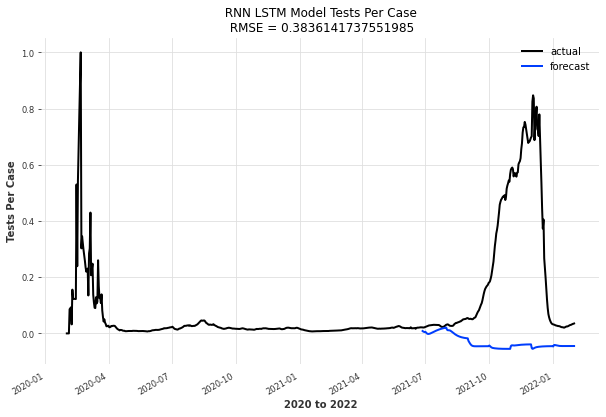

In [72]:
# Attribute: tests_per_case    
# Evaluating and plotting model
n_val_tests_per_case = len(ts_tests_per_case_val)

def eval_model_tests_per_case(model):
    pred_series = model.predict(n = n_val_tests_per_case, future_covariates = covariates_tests_per_case)
    plt.figure(figsize=(10, 6))
    ts_tests_per_case_scaled.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title(' RNN LSTM Model Tests Per Case \n RMSE = {}'.format(rmse(pred_series, ts_tests_per_case_val)))
    plt.xlabel('2020 to 2022')
    plt.ylabel('Tests Per Case')
    plt.legend()

eval_model_tests_per_case(LSTM_model_tests_per_case)

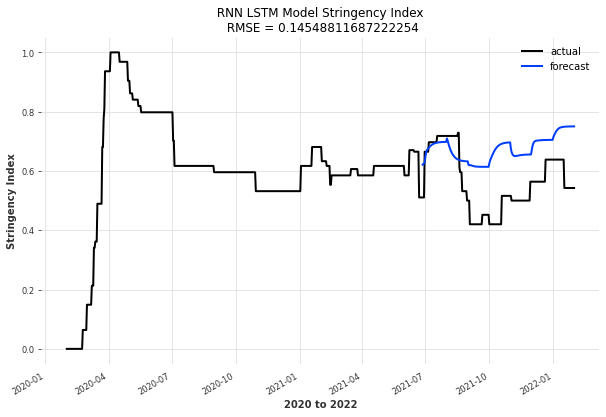

In [73]:
# Attribute: stringency_index   
# Evaluating and plotting model
n_val_stringency_index = len(ts_stringency_index_val)

def eval_model_stringency_index(model):
    pred_series = model.predict(n = n_val_stringency_index, future_covariates = covariates_stringency_index)
    plt.figure(figsize=(10, 6))
    ts_stringency_index_scaled.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title(' RNN LSTM Model Stringency Index \n RMSE = {}'.format(rmse(pred_series, ts_stringency_index_val)))
    plt.xlabel('2020 to 2022')
    plt.ylabel('Stringency Index')
    plt.legend()

eval_model_stringency_index(LSTM_model_stringency_index)

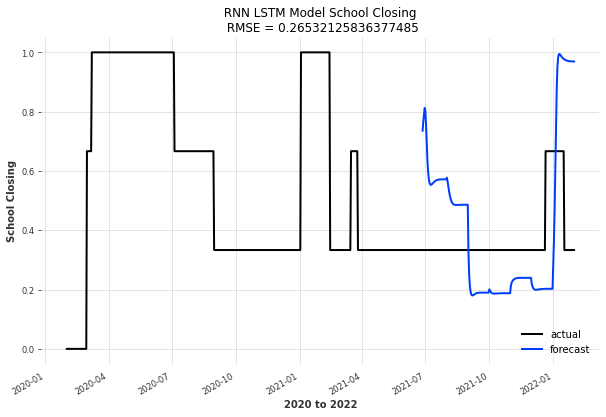

In [74]:
# Attribute: C1_School_closing    
# Evaluating and plotting model
n_val_C1_School_closing = len(ts_C1_School_closing_val)

def eval_model_C1_School_closing(model):
    pred_series = model.predict(n = n_val_C1_School_closing, future_covariates = covariates_C1_School_closing)
    plt.figure(figsize=(10, 6))
    ts_C1_School_closing_scaled.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title(' RNN LSTM Model School Closing \n RMSE = {}'.format(rmse(pred_series, ts_C1_School_closing_val)))
    plt.xlabel('2020 to 2022')
    plt.ylabel('School Closing')
    plt.legend()

eval_model_C1_School_closing(LSTM_model_C1_School_closing)

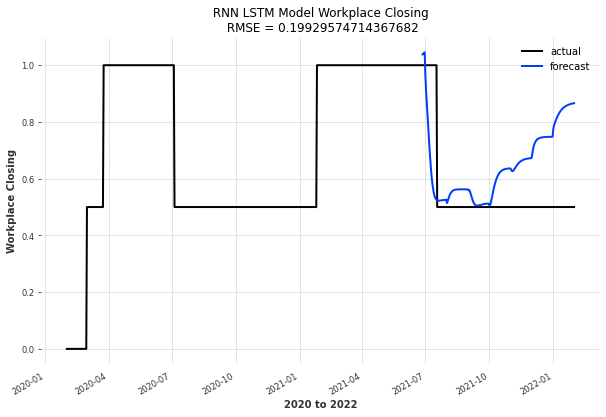

In [75]:
# Attribute: C2_Workplace_closing    
# Evaluating and plotting model
n_val_C2_Workplace_closing = len(ts_C2_Workplace_closing_val)

def eval_model_C2_Workplace_closing(model):
    pred_series = model.predict(n = n_val_C2_Workplace_closing, future_covariates = covariates_C2_Workplace_closing)
    plt.figure(figsize=(10, 6))
    ts_C2_Workplace_closing_scaled.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title(' RNN LSTM Model Workplace Closing \n RMSE = {}'.format(rmse(pred_series, ts_C2_Workplace_closing_val)))
    plt.xlabel('2020 to 2022')
    plt.ylabel('Workplace Closing')
    plt.legend()

eval_model_C2_Workplace_closing(LSTM_model_C2_Workplace_closing)

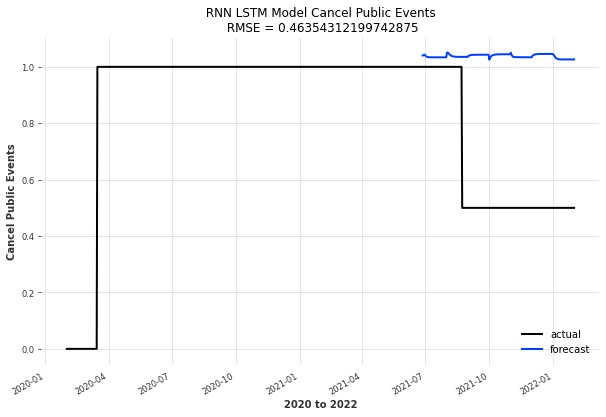

In [76]:
# Attribute: C3_Cancel_public_events    
# Evaluating and plotting model
n_val_C3_Cancel_public_events = len(ts_C3_Cancel_public_events_val)

def eval_model_C3_Cancel_public_events(model):
    pred_series = model.predict(n = n_val_C3_Cancel_public_events, future_covariates = covariates_C3_Cancel_public_events)
    plt.figure(figsize=(10, 6))
    ts_C3_Cancel_public_events_scaled.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title(' RNN LSTM Model Cancel Public Events \n RMSE = {}'.format(rmse(pred_series, ts_C3_Cancel_public_events_val)))
    plt.xlabel('2020 to 2022')
    plt.ylabel('Cancel Public Events')
    plt.legend()

eval_model_C3_Cancel_public_events(LSTM_model_C3_Cancel_public_events)

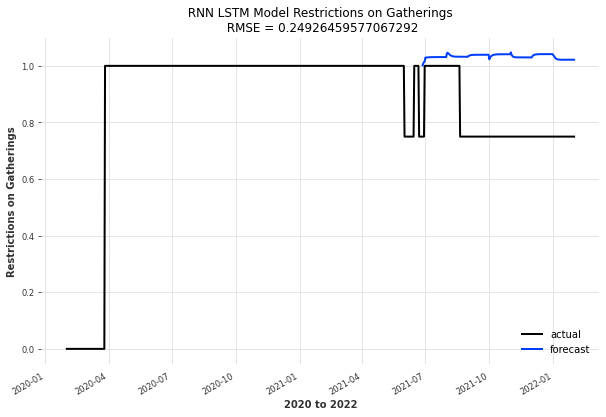

In [77]:
# Attribute: C4_Restrictions_on_gatherings    
# Evaluating and plotting model
n_val_C4_Restrictions_on_gatherings = len(ts_C4_Restrictions_on_gatherings_val)

def eval_model_C4_Restrictions_on_gatherings(model):
    pred_series = model.predict(n = n_val_C4_Restrictions_on_gatherings, future_covariates = covariates_C4_Restrictions_on_gatherings)
    plt.figure(figsize=(10, 6))
    ts_C4_Restrictions_on_gatherings_scaled.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title(' RNN LSTM Model Restrictions on Gatherings \n RMSE = {}'.format(rmse(pred_series, ts_C4_Restrictions_on_gatherings_val)))
    plt.xlabel('2020 to 2022')
    plt.ylabel('Restrictions on Gatherings')
    plt.legend()

eval_model_C4_Restrictions_on_gatherings(LSTM_model_C4_Restrictions_on_gatherings)

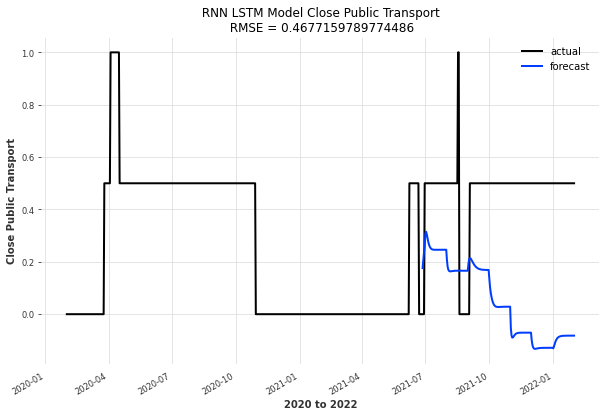

In [78]:
# Attribute: C5_Close_public_transport  
# Evaluating and plotting model
n_val_C5_Close_public_transport = len(ts_C5_Close_public_transport_val)

def eval_model_C5_Close_public_transport(model):
    pred_series = model.predict(n = n_val_C5_Close_public_transport, future_covariates = covariates_C5_Close_public_transport)
    plt.figure(figsize=(10, 6))
    ts_C5_Close_public_transport_scaled.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title(' RNN LSTM Model Close Public Transport \n RMSE = {}'.format(rmse(pred_series, ts_C5_Close_public_transport_val)))
    plt.xlabel('2020 to 2022')
    plt.ylabel('Close Public Transport')
    plt.legend()

eval_model_C5_Close_public_transport(LSTM_model_C5_Close_public_transport)

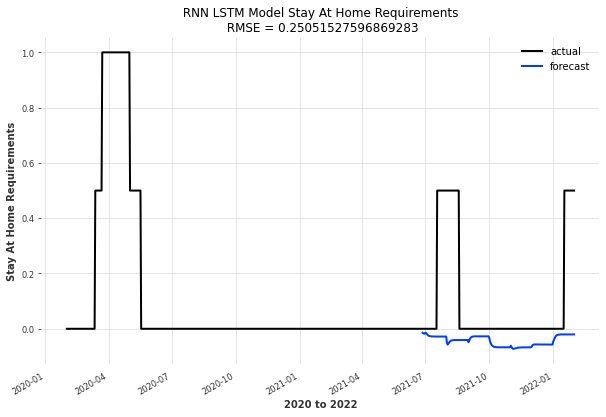

In [79]:
# Attribute: C6_Stay_at_home_requirements  
# Evaluating and plotting model
n_val_C6_Stay_at_home_requirements = len(ts_C6_Stay_at_home_requirements_val)

def eval_model_C6_Stay_at_home_requirements(model):
    pred_series = model.predict(n = n_val_C6_Stay_at_home_requirements, future_covariates = covariates_C6_Stay_at_home_requirements)
    plt.figure(figsize=(10, 6))
    ts_C6_Stay_at_home_requirements_scaled.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title(' RNN LSTM Model Stay At Home Requirements \n RMSE = {}'.format(rmse(pred_series, ts_C6_Stay_at_home_requirements_val)))
    plt.xlabel('2020 to 2022')
    plt.ylabel('Stay At Home Requirements')
    plt.legend()

eval_model_C6_Stay_at_home_requirements(LSTM_model_C6_Stay_at_home_requirements)

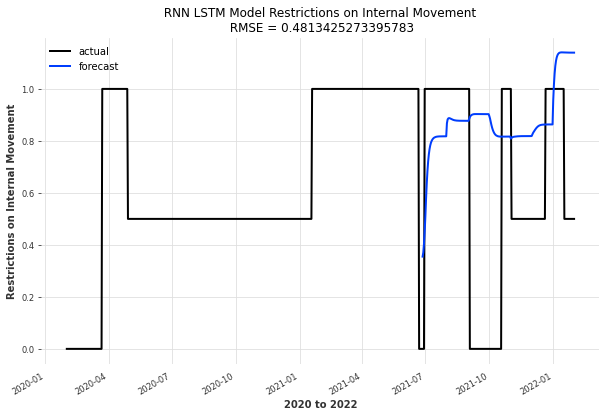

In [80]:
# Attribute: C7_Restrictions_on_internal_movement  
# Evaluating and plotting model
n_val_C7_Restrictions_on_internal_movement = len(ts_C7_Restrictions_on_internal_movement_val)

def eval_model_C7_Restrictions_on_internal_movement(model):
    pred_series = model.predict(n = n_val_C7_Restrictions_on_internal_movement, future_covariates = covariates_C7_Restrictions_on_internal_movement)
    plt.figure(figsize=(10, 6))
    ts_C7_Restrictions_on_internal_movement_scaled.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title(' RNN LSTM Model Restrictions on Internal Movement \n RMSE = {}'.format(rmse(pred_series, ts_C7_Restrictions_on_internal_movement_val)))
    plt.xlabel('2020 to 2022')
    plt.ylabel('Restrictions on Internal Movement')
    plt.legend()

eval_model_C7_Restrictions_on_internal_movement(LSTM_model_C7_Restrictions_on_internal_movement)

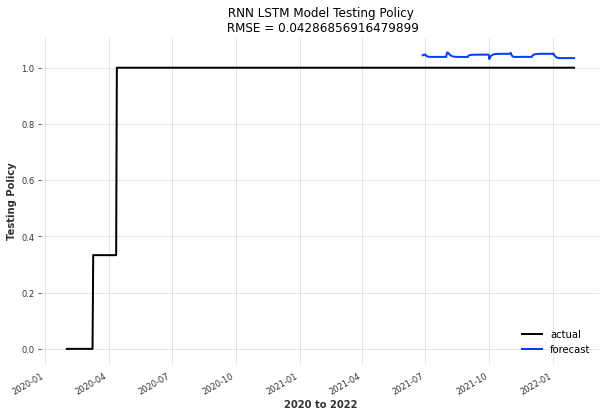

In [81]:
# Attribute: H2_Testing_policy  
# Evaluating and plotting model
n_val_H2_Testing_policy = len(ts_H2_Testing_policy_val)

def eval_model_H2_Testing_policy(model):
    pred_series = model.predict(n = n_val_H2_Testing_policy, future_covariates = covariates_H2_Testing_policy)
    plt.figure(figsize=(10, 6))
    ts_H2_Testing_policy_scaled.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title(' RNN LSTM Model Testing Policy \n RMSE = {}'.format(rmse(pred_series, ts_H2_Testing_policy_val)))
    plt.xlabel('2020 to 2022')
    plt.ylabel('Testing Policy')
    plt.legend()

eval_model_H2_Testing_policy(LSTM_model_H2_Testing_policy)

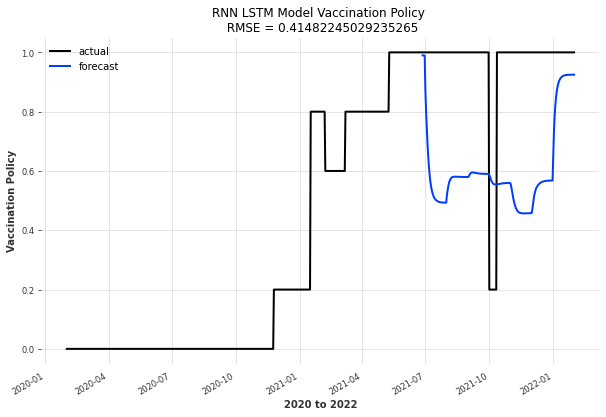

In [82]:
# Attribute: H7_Vaccination_policy
# Evaluating and plotting model
n_val_H7_Vaccination_policy = len(ts_H7_Vaccination_policy_val)

def eval_model_H7_Vaccination_policy(model):
    pred_series = model.predict(n = n_val_H7_Vaccination_policy, future_covariates = covariates_H7_Vaccination_policy)
    plt.figure(figsize=(10, 6))
    ts_H7_Vaccination_policy_scaled.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title('RNN LSTM Model Vaccination Policy \n RMSE = {}'.format(rmse(pred_series, ts_H7_Vaccination_policy_val)))
    plt.xlabel('2020 to 2022')
    plt.ylabel('Vaccination Policy')
    plt.legend()

eval_model_H7_Vaccination_policy(LSTM_model_H7_Vaccination_policy)

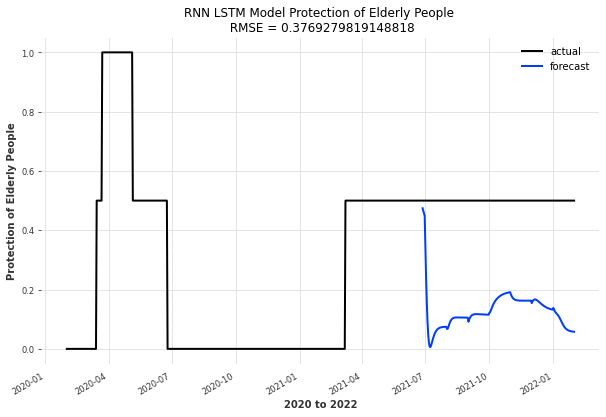

In [83]:
# Attribute: H8_Protection_of_elderly_people
# Evaluating and plotting model
n_val_H8_Protection_of_elderly_people = len(ts_H8_Protection_of_elderly_people_val)

def eval_model_H8_Protection_of_elderly_people(model):
    pred_series = model.predict(n = n_val_H8_Protection_of_elderly_people, future_covariates = covariates_H8_Protection_of_elderly_people)
    plt.figure(figsize=(10, 6))
    ts_H8_Protection_of_elderly_people_scaled.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title('RNN LSTM Model Protection of Elderly People \n RMSE = {}'.format(rmse(pred_series, ts_H8_Protection_of_elderly_people_val)))
    plt.xlabel('2020 to 2022')
    plt.ylabel('Protection of Elderly People')
    plt.legend()

eval_model_H8_Protection_of_elderly_people(LSTM_model_H8_Protection_of_elderly_people)